In [1]:
from datasets import load_dataset
import pandas as pd

# 1. Téléchargement du dataset
# Le nom sur le hub est "dair-ai/emotion"
dataset = load_dataset("dair-ai/emotion")

# 2. Aperçu de la structure
print(dataset)

/home/lionel/DEVIA/NLP_/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [2]:
print(max(len(x) for x in dataset['train']['text']))
print(max(len(x) for x in dataset['validation']['text']))
print(max(len(x) for x in dataset['test']['text']))


300
295
296


In [3]:
from nltk.tokenize import word_tokenize

print(max(len(word_tokenize(x)) for x in dataset['train']['text']))
print(max(len(word_tokenize(x)) for x in dataset['validation']['text']))
print(max(len(word_tokenize(x)) for x in dataset['test']['text']))



66
61
61


In [31]:
dataset_train = pd.DataFrame(dataset['train'])
dataset_test = pd.DataFrame(dataset['test'])
dataset_validation = pd.DataFrame(dataset['validation'])

In [ ]:
# from sklearn.utils import resample

# df_0 = dataset_train[dataset_train['label'] == 0]
# df_1 = dataset_train[dataset_train['label'] == 1]
# df_2 = dataset_train[dataset_train['label'] == 2]
# df_3 = dataset_train[dataset_train['label'] == 3]
# df_4 = dataset_train[dataset_train['label'] == 4]
# df_5 = dataset_train[dataset_train['label'] == 5]

# # On cible 3000 exemples par classe
# n_target = 1300

# df_0_bal = resample(df_0, replace=False, n_samples=n_target, random_state=42)
# df_1_bal = resample(df_1, replace=False, n_samples=n_target, random_state=42)
# df_2_bal = resample(df_2, replace=False, n_samples=n_target, random_state=42)
# df_3_bal = resample(df_3, replace=False, n_samples=n_target, random_state=42)
# df_4_bal = resample(df_4, replace=False, n_samples=n_target, random_state=42)

# # Pour les petites (5) : on augmente (Oversampling simple)

# df_5_bal = resample(df_5, replace=True, n_samples=n_target, random_state=42)

# # La classe 2 est déjà à 1304, on la garde telle quelle
# df_balanced = pd.concat([df_0_bal, df_1_bal, df_2_bal, df_3_bal, df_4_bal, df_5_bal])

In [63]:
df_balanced = dataset_train

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Initialize the Tokenizer
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['text'])
word_index = tokenizer.word_index

# 3. Turn the strings into lists of integers
X_train_sequences = tokenizer.texts_to_sequences(df_balanced['text'])
X_val_sequences = tokenizer.texts_to_sequences(dataset['validation']['text'])
X_test_sequences = tokenizer.texts_to_sequences(dataset['test']['text'])

# 4. NOW you can pad them
X_train_padded = pad_sequences(X_train_sequences, maxlen=80, padding='pre')
X_val_padded = pad_sequences(X_val_sequences, maxlen=80, padding='pre')
X_test_padded = pad_sequences(X_test_sequences, maxlen=80, padding='pre')

# 4. NOW you can pad them
X_train_padded_post = pad_sequences(X_train_sequences, maxlen=80, padding='post')
X_val_padded_post = pad_sequences(X_val_sequences, maxlen=80, padding='post')
X_test_padded_post = pad_sequences(X_test_sequences, maxlen=80, padding='post')

print(X_train_padded[1]) 
print(X_train_padded_post[1]) 
# You should see a beautiful array of numbers now!

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    2   40  101   60    8   15  494    5   15 3496  553
   32   60   61  128  148   76 1480    4   22 1255]
[   2   40  101   60    8   15  494    5   15 3496  553   32   60   61
  128  148   76 1480    4   22 1255    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [65]:
import numpy as np

X_train_final = np.array(X_train_padded)
y_train_final = np.array(df_balanced['label'])

X_val_final = np.array(X_val_padded)
y_val_final = np.array(dataset['validation']['label'])

X_test_final = np.array(X_test_padded)
y_test_final = np.array(dataset['test']['label'])

In [67]:
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam

vocab_size = min(max_words, len(word_index) + 1)

def create_model():
    model = Sequential([
        layers.Input(shape=(70,)),
        layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True),
        layers.LSTM(64),
        layers.Dropout(0.2),
        layers.Dense(6, activation='softmax')
        ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
    return model


In [84]:
import tensorflow as tf

class TransformerSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# --- CONFIGURATION ---
# d_model correspond souvent à l'output_dim de ton Embedding (ici 128)
# Attention : warmup_steps=4 est très court. Dans la recherche, on utilise 
# souvent 4000. Pour ton petit dataset, essaie peut-être 400 ou 800.
d_model = 128
warmup_steps = 400 # Ajusté car 4 est trop faible pour stabiliser

lr_schedule = TransformerSchedule(d_model=d_model, warmup_steps=warmup_steps)


# Utilisation dans l'optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model = create_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
    X_train_final, 
    y_train_final, 
    epochs=10, 
    batch_size=128, 
    validation_data=(X_val_final, y_val_final), 
    verbose=1)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.3623 - loss: 1.6118 - val_accuracy: 0.5295 - val_loss: 1.2901
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.7376 - loss: 0.7715 - val_accuracy: 0.8275 - val_loss: 0.4967
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9104 - loss: 0.2765 - val_accuracy: 0.8910 - val_loss: 0.3211
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9499 - loss: 0.1523 - val_accuracy: 0.9030 - val_loss: 0.3005
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9654 - loss: 0.1005 - val_accuracy: 0.9090 - val_loss: 0.3213
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.9772 - loss: 0.0644 - val_accuracy: 0.9160 - val_loss: 0.2786
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.9855 - loss: 0.0432 - val_accuracy: 0.9165 - val_loss: 0.3241
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9894 - loss: 0.0304

In [85]:
y_pred = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


--- RAPPORT DE CLASSIFICATION (LSTM) ---
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       581
           1       0.90      0.95      0.92       695
           2       0.83      0.74      0.78       159
           3       0.91      0.87      0.89       275
           4       0.90      0.84      0.87       224
           5       0.76      0.71      0.73        66

    accuracy                           0.90      2000
   macro avg       0.87      0.84      0.86      2000
weighted avg       0.90      0.90      0.90      2000



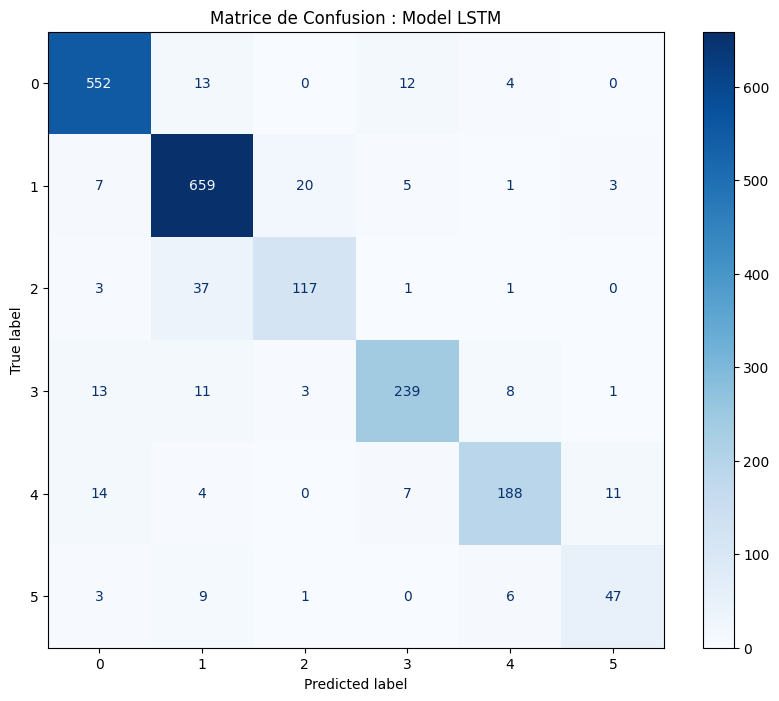

In [86]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("--- RAPPORT DE CLASSIFICATION (LSTM) ---")
print(classification_report(y_test_final, y_pred_classes))

# Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred_classes, ax=ax, cmap='Blues')
plt.title("Matrice de Confusion : Model LSTM")
plt.show()

## Transfert learning

In [47]:
import gensim.downloader as api
# --- 3. CHARGEMENT DU SAVOIR DE GOOGLE (Word2Vec) ---
# Téléchargement du modèle pré-entraîné
print("Chargement de Word2Vec Google News...")
google_model = api.load("word2vec-google-news-300")

Chargement de Word2Vec Google News...


In [71]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in google_model:
        # On injecte le vecteur de Google à la ligne correspondante
        embedding_matrix[i] = google_model[word]

In [72]:
import keras
embedding_layer = layers.Embedding(
    input_dim=vocab_size,
    output_dim=300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,  # On "gèle" pour ne pas perdre le savoir de Google
    mask_zero=True    # On ignore les zéros du padding
)

print("Pipeline terminé : La couche d'embedding est prête à être intégrée !")

Pipeline terminé : La couche d'embedding est prête à être intégrée !


In [73]:
def create_model_google():
    model = Sequential([
        layers.Input(shape=(70,)),
        embedding_layer,
        layers.LSTM(64),
        layers.Dropout(0.2),
        layers.Dense(6, activation='softmax')
        ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
    return model

In [74]:
def create_model_google2():
    model = Sequential([
        layers.Input(shape=(70,)),
        embedding_layer,
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.5), # Augmenté pour contrer l'overfitting de l'oversampling
        layers.Dense(64, activation='relu'),
        layers.Dense(6, activation='softmax')
        ])
    return model

In [75]:
import tensorflow as tf

class TransformerSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# --- CONFIGURATION ---
# d_model correspond souvent à l'output_dim de ton Embedding (ici 128)
# Attention : warmup_steps=4 est très court. Dans la recherche, on utilise 
# souvent 4000. Pour ton petit dataset, essaie peut-être 400 ou 800.
d_model = 128
warmup_steps = 400 # Ajusté car 4 est trop faible pour stabiliser

lr_schedule = TransformerSchedule(d_model=d_model, warmup_steps=warmup_steps)


# Utilisation dans l'optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model = create_model_google2()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
    X_train_final, 
    y_train_final, 
    epochs=20, 
    batch_size=128, 
    validation_data=(X_val_final, y_val_final), 
    verbose=1)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 318ms/step - accuracy: 0.3968 - loss: 1.5292 - val_accuracy: 0.5740 - val_loss: 1.2004
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.6564 - loss: 0.9519 - val_accuracy: 0.7935 - val_loss: 0.6092
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.8280 - loss: 0.4938 - val_accuracy: 0.8675 - val_loss: 0.3678
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.8944 - loss: 0.2990 - val_accuracy: 0.9205 - val_loss: 0.2340
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step - accuracy: 0.9227 - loss: 0.2061 - val_accuracy: 0.9220 - val_loss: 0.1993
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 276ms/step - accuracy: 0.9359 - loss: 0.1549 - val_accuracy: 0.9345 - val_loss: 0.1541
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 247ms/step - accuracy: 0.9406 - loss: 0.1325 - val_accuracy: 0.9355 - val_loss: 0.1268
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - accuracy: 0.9421 - loss: 0

In [76]:
y_pred = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step


--- RAPPORT DE CLASSIFICATION (Google) ---
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.96      0.93      0.94       695
           2       0.77      0.91      0.83       159
           3       0.96      0.91      0.94       275
           4       0.88      0.91      0.89       224
           5       0.75      0.77      0.76        66

    accuracy                           0.93      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



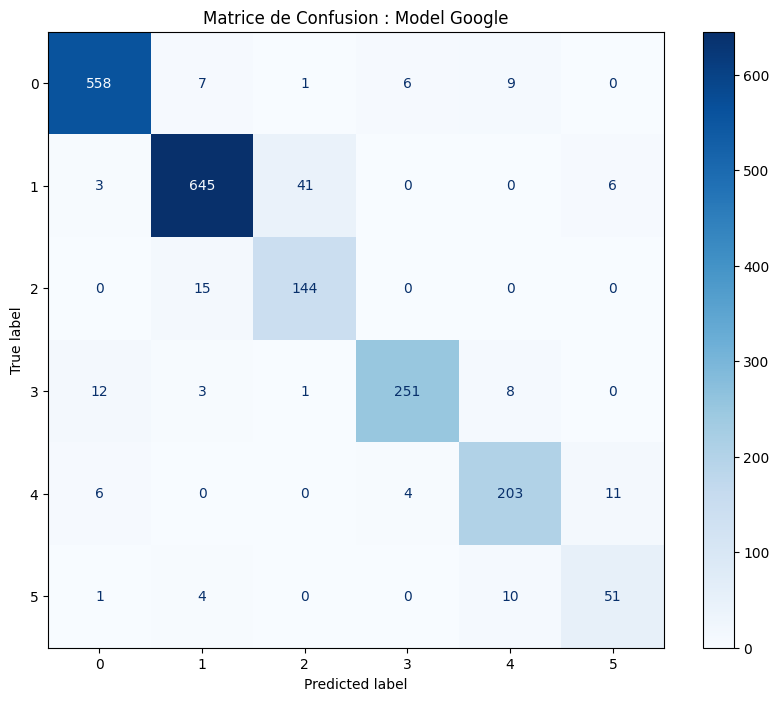

In [77]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("--- RAPPORT DE CLASSIFICATION (Google) ---")
print(classification_report(y_test_final, y_pred_classes))

# Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred_classes, ax=ax, cmap='Blues')
plt.title("Matrice de Confusion : Model Google")
plt.show()

In [81]:
def predict_emotion(sentence):
    # 1. Prétraitement (doit être identique à l'entraînement)
    sequence = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(sequence, maxlen=80, padding='pre')
    
    # 2. Prédiction
    prediction = model.predict(padded, verbose=0)
    class_idx = np.argmax(prediction)
    prob = np.max(prediction)
    
    # 3. Mapping des noms
    names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    
    print(f"Phrase : '{sentence}'")
    print(f"Émotion : {names[class_idx]} ({prob*100:.2f}%)")

# Teste-le !
predict_emotion("I can't believe I finally solved all these bugs!")
predict_emotion("I feel a bit overwhelmed by all this work.")
predict_emotion("I just got a promotion at work!")
predict_emotion("I'm so excited about my new job!")
predict_emotion("I am really scared about the upcoming presentation.")
predict_emotion("I am overwhelmed by this amazing surprise!")
predict_emotion("I am overwhelmed by this terrible tragedy.")

Phrase : 'I can't believe I finally solved all these bugs!'
Émotion : joy (99.57%)
Phrase : 'I feel a bit overwhelmed by all this work.'
Émotion : surprise (56.52%)
Phrase : 'I just got a promotion at work!'
Émotion : joy (54.59%)
Phrase : 'I'm so excited about my new job!'
Émotion : joy (99.98%)
Phrase : 'I am really scared about the upcoming presentation.'
Émotion : fear (99.96%)
Phrase : 'I am overwhelmed by this amazing surprise!'
Émotion : surprise (95.47%)
Phrase : 'I am overwhelmed by this terrible tragedy.'
Émotion : fear (65.09%)


### History du Model Embedding google

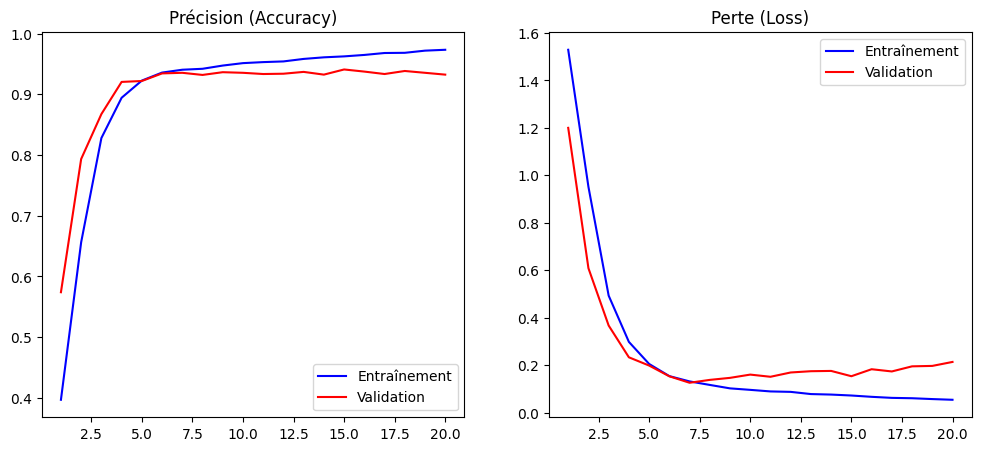

In [82]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Graphique de l'Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Entraînement')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Précision (Accuracy)')
    plt.legend()

    # Graphique de la Perte (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Entraînement')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Perte (Loss)')
    plt.legend()

    plt.show()

plot_history(history)

### History du Model Embedding classic

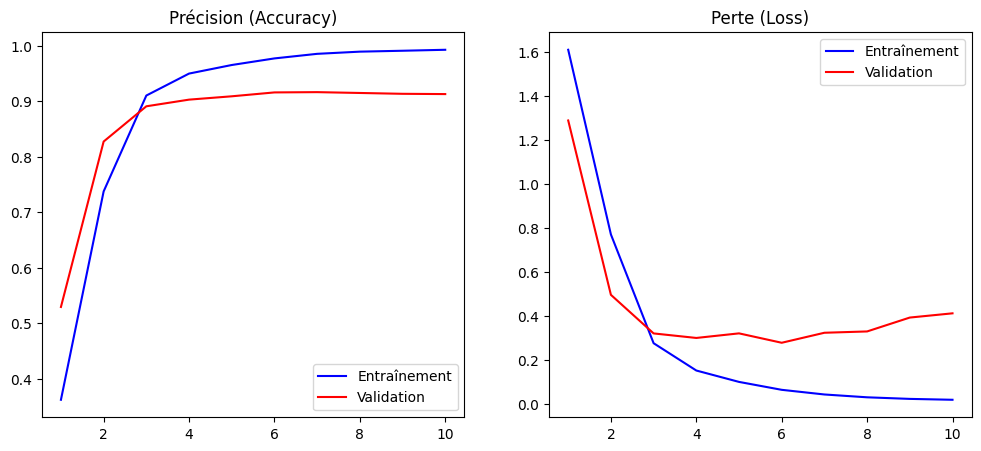

In [87]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Graphique de l'Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Entraînement')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Précision (Accuracy)')
    plt.legend()

    # Graphique de la Perte (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Entraînement')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Perte (Loss)')
    plt.legend()

    plt.show()

plot_history(history)

In [93]:
import pandas as pd
names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
y_pred_probs = model.predict(X_test_final)

pd.set_option('display.max_colwidth', None)  # Enlève la limite de largeur des colonnes
pd.set_option('display.max_rows', 200)        # Affiche jusqu'à 50 lignes si besoin

# Créer un DataFrame avec les textes originaux du test
df_errors = pd.DataFrame({
    'Texte': dataset['test']['text'],
    'Vrai': [names[i] for i in y_test_final],
    'Prédit': [names[i] for i in y_pred_classes],
    'Confiance': np.max(y_pred_probs, axis=1)
})

# Filtrer uniquement les erreurs
errors_only = df_errors[df_errors['Vrai'] != df_errors['Prédit']]

# Trier par les erreurs où le modèle était le plus "sûr" de lui
print("--- TOP 10 DES ERREURS LES PLUS 'CONFIDENTES' ---")
errors_only.sort_values(by='Confiance', ascending=False).head(200)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
--- TOP 10 DES ERREURS LES PLUS 'CONFIDENTES' ---


,Texte,Vrai,Prédit,Confiance
426,i feel unprotected a class post count link href http reprogramming in process,sadness,fear,0.999997
1928,i feel inside cause life is like a game sometimes but then you came around me the walls just disappeared nothing to surround me and keep me from my fears im unprotected see how ive opened up youve made me trust,fear,sadness,0.999993
1275,i feel so weird and scattered with all wonders about a million different things,surprise,fear,0.999984
242,i see you on the pitchers mound at our little league diamond i feel so anxious for you because it looks so isolated over there,fear,sadness,0.999983
1949,im feeling good these days and my only complaints are that its getting harder and harder to move around and chase after stone and its getting harder and harder to find clothes that fit,joy,love,0.999981
1641,i am not feeling the love towards myself and that becomes somewhat of a vicious circle resulting in me just feeling lazy complacent and in general just de motivated,anger,joy,0.999981
234,i love to dance but often feel inhibited by my own body unsure what i am capable of hyper concerned about other people watching me and having opinions on my style or just feeling awkward as if i have no idea what i am supposed to do here,fear,sadness,0.999976
1506,i already feel him kicking my ribs making it harder to breath sometimes and taking over precious space where my stomach once was,joy,sadness,0.999954
415,i loved the feeling i got during an amazing slalom run whether it was in training or in a race,joy,surprise,0.999932
1683,i blamed the people around me for making me feel less valued for being a stay at home mom,joy,sadness,0.999925
